# Hate Speech Detector 2.0
---
**Initial data analysis**
1. Selection of **relevant tweet data**.
    1. {'new_id', 'date', 'time', 'user_id', 'username', 'name', 'tweet', 'emojis', 'emoticons', 'mentions'}
    2. {'hashtags', 'reply_to', 'replies_count', 'retweets_count', 'likes_count'}
2. Combining selected data with their annotations and saving into separate files.
3. Cardinalities and combination of hate-speech **class amounts**.
4. Loading the hateful phrases from combined data. Saving dictionaries.
5. Loading the **vulgar phrases** from three sources: (Saving dictionaries.)
    1. Polish vulgar words [Marcinmazurek.com.pl](http://marcinmazurek.com.pl/polskie-wulgaryzmy)
    2. Polish vulgar words [Github.com](https://github.com/coldner/wulgaryzmy)
    3. Polish vulgar words & phrases [Pl.wiktionary.org](https://pl.wiktionary.org/wiki/Indeks:Polski_-_Wulgaryzmy)
6. Hateful and vulgar **phrases quantitative and qualitive analysis**.
    1. How many distinct phrases exists for each hate-speech class and vulgars.
    2. Which percentage of the whole determine the phrases for each hate-speech class and vulgars.
7. Empirically annotated sentiment analysis. (quantitive only)
8. Appropriate visualizations for each analysis.
9. Saving of each of initial dictionaries and visualizations.

In [1]:
import numpy as np
import pandas as pd

import re
import os
import csv

import matplotlib.pyplot as plt

from src.utils.raw import save_raw_phrases, save_raw_vulgars
from src.utils.ops import union3
from src.dataframes.utils import classes, phrases
from src.dataframes.cards import class_single_cards, class_combination_cards, phrase_cards
from src.visualization.cards import (single_cardinalities_bar, combination_cardinalities_upset,
                                     phrase_cardinalities_bar, vulgars_cardinalities_venn,
                                     sentiment_counts_pie)
from src.constants import (ANNOTATED_PATH, SANITIZED_PATH, COMBINED_PATH,
                           HATEFUL_RAW_DIR, VULGARS_RAW_DIR,
                           LABELS, LABELS_SMALL,
                           ANNOTATED_COLS, INFOS_COLS, COMBINED_COLS)

In [2]:
pd.set_option('display.max_colwidth', 400)

In [3]:
plt.style.use('ggplot')

## Selection of relevant data

In [4]:
df_infos = pd.read_csv(SANITIZED_PATH)
df_infos.head(2)

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,new_id
0,"4,74999593189773E+017","4,74982910425301E+017",1402083702000,2014-06-06,21:41:42,CEST,2367137142,krzysztofcicho3,Krzysztof Cichosz,NaN,...,NaN,NaN,NaN,NaN,"[{'user_id': '2367137142', 'username': 'KrzysztofCicho3'}, {'user_id': '244246777', 'username': 'TomSokolewicz'}]",NaN,NaN,NaN,NaN,0
1,"4,74958618094105E+017","4,74958618094105E+017",1402073933000,2014-06-06,18:58:53,CEST,780543464,zalewski53,Roland Zalewski,NaN,...,NaN,NaN,NaN,NaN,"[{'user_id': '780543464', 'username': 'Zalewski53'}]",NaN,NaN,NaN,NaN,1


In [5]:
df_infos.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'emojis', 'emoticons',
       'mentions', 'urls', 'photos', 'replies_count', 'retweets_count',
       'likes_count', 'hashtags', 'cashtags', 'link', 'retweet', 'quote_url',
       'video', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id',
       'reply_to', 'retweet_date', 'translate', 'trans_src', 'trans_dest',
       'new_id'],
      dtype='object')

In [6]:
df_annotated = pd.read_csv(ANNOTATED_PATH, sep='\t')
df_annotated = df_annotated[ANNOTATED_COLS]
df_annotated.head()

,id,wydźwięk,klucze,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_infos = df_infos[INFOS_COLS]
df_infos['new_id'] = df_infos['new_id'].astype(int)
df_infos.head(2)

,new_id,date,time,user_id,username,name,tweet,emojis,emoticons,mentions,hashtags,reply_to,replies_count,retweets_count,likes_count
0,0,2014-06-06,21:41:42,2367137142,krzysztofcicho3,Krzysztof Cichosz,Dokładnie! Dlatego trzeba komuchów gonić przed sądy póki żyją. I mięć otwarte oczy na komuchów zakamuflowanych,NaN,NaN,['tomsokolewicz'],[],"[{'user_id': '2367137142', 'username': 'KrzysztofCicho3'}, {'user_id': '244246777', 'username': 'TomSokolewicz'}]",0,0,0
1,1,2014-06-06,18:58:53,780543464,zalewski53,Roland Zalewski,Polska Polityka: Sądy bardziej bezkarne niż w PRL,NaN,NaN,[],[],"[{'user_id': '780543464', 'username': 'Zalewski53'}]",0,0,0


## Combining data

In [8]:
df_combined = df_infos.merge(df_annotated, left_on='new_id', right_on='id')
df_combined.head(2)

,new_id,date,time,user_id,username,name,tweet,emojis,emoticons,mentions,...,id,wydźwięk,klucze,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,2014-06-06,21:41:42,2367137142,krzysztofcicho3,Krzysztof Cichosz,Dokładnie! Dlatego trzeba komuchów gonić przed sądy póki żyją. I mięć otwarte oczy na komuchów zakamuflowanych,NaN,NaN,['tomsokolewicz'],...,0,-1,komuchów; gonić komuchów,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-06-06,18:58:53,780543464,zalewski53,Roland Zalewski,Polska Polityka: Sądy bardziej bezkarne niż w PRL,NaN,NaN,[],...,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_combined.columns

Index(['new_id', 'date', 'time', 'user_id', 'username', 'name', 'tweet',
       'emojis', 'emoticons', 'mentions', 'hashtags', 'reply_to',
       'replies_count', 'retweets_count', 'likes_count', 'id', 'wydźwięk',
       'klucze', 'wyzywanie', 'grożenie', 'wykluczanie', 'odczłowieczanie',
       'poniżanie', 'stygmatyzacja', 'szantaż'],
      dtype='object')

In [10]:
df_combined = df_combined[COMBINED_COLS]
df_combined.head(2)

,id,date,time,user_id,username,name,tweet,emojis,emoticons,mentions,...,likes_count,wydźwięk,klucze,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,2014-06-06,21:41:42,2367137142,krzysztofcicho3,Krzysztof Cichosz,Dokładnie! Dlatego trzeba komuchów gonić przed sądy póki żyją. I mięć otwarte oczy na komuchów zakamuflowanych,NaN,NaN,['tomsokolewicz'],...,0,-1,komuchów; gonić komuchów,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-06-06,18:58:53,780543464,zalewski53,Roland Zalewski,Polska Polityka: Sądy bardziej bezkarne niż w PRL,NaN,NaN,[],...,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_combined.to_csv(COMBINED_PATH, index=False)

## Class cardinalities

### Single classes
**GENERALLY** How many examples belong to each class?

In [12]:
df_classes = classes(df_combined, convert_null=True)
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0


In [13]:
df_single_cards = class_single_cards(df_classes)
df_single_cards

,cardinality,%
label,,
total,15202,100.000000
stygmatyzacja,830,5.459808
poniżanie,700,4.604657
grożenie,393,2.585186
wyzywanie,242,1.591896
odczłowieczanie,174,1.144586
wykluczanie,94,0.618340
szantaż,6,0.039468


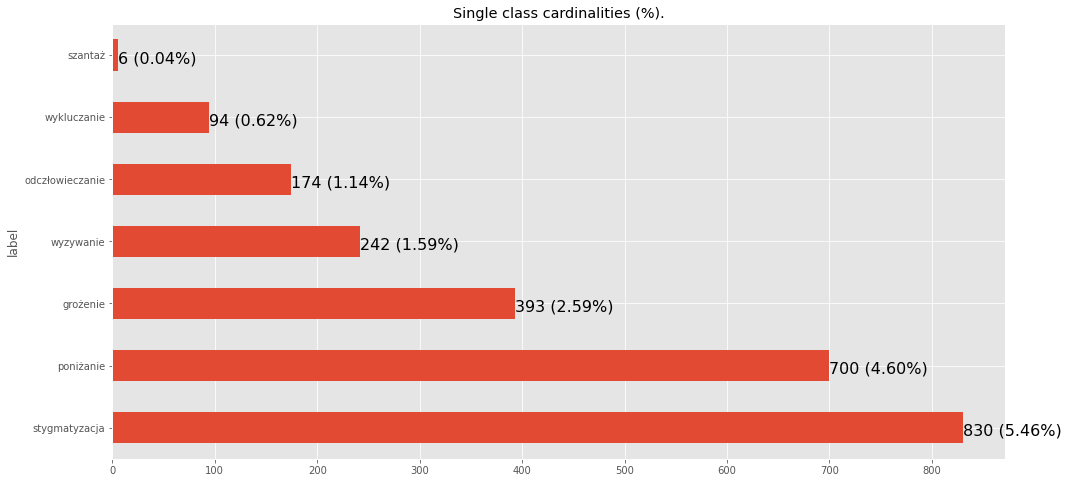

In [14]:
single_cardinalities_bar(df_single_cards)

The 'stygmatyzacja' (5.45%) and 'poniżanie' (4.60%) labels are at the top. The 'wykluczanie' (0.62%) and 'szantaż' (0.04%) are at the bottom.

### Combinations of classes
**SPECIFICALLY** How many examples belong to each combination of classes?

In [15]:
df_combination_cards = class_combination_cards(df_classes)
df_combination_cards

cardinality  \
wyzywanie grożenie wykluczanie odczłowieczanie poniżanie stygmatyzacja szantaż                
0         0        0           0               0         0             0              13654   
                                                         1             0                361   
                                               1         0             0                251   
                                                         1             0                197   
          1        0           0               0         0             0                179   
                                                         1             0                106   
1         0        0           0               1         0             0                 57   
                                               0         0             0                 43   
                               1               1         1             0                 40   
0         0        0           1               0         0             0                 36   
          1        1           0               0         0             0                 32   
1         0        0           0               1         1             0                 32   
0         0        0           1               1         0             0                 23   
          1        0           0               1         0             0                 20   
1         0        0           0               0         1             0                 20   
                               1               1         0             0                 15   
0         0        1           0               0         0             0                 13   
                   0           1               0         1             0                 13   
                                               1         1             0                 11   
                   1           0               1         0             0                 10   
          1        0           0               1         1             0                  8   
1         0        0           1               0         1             0                  7   
0         0        1           0               0         1             0                  6   
          1        0           1               0         1             0                  6   
1         1        0           0               0         0             0                  5   
0         1        0           1               1         0             0                  5   
1         1        0           0               1         0             0                  4   
          0        1           0               1         1             0                  4   
0         1        1           0               0         1             0                  4   
                   0           1               0         0             0                  4   
                   1           0               1         1             0                  3   
          0        0           0               0         0             1                  3   
          1        0           1               1         1             0                  3   
          0        1           0               1         1             0                  3   
          1        1           1               0         0             0                  2   
1         1        1           0               1         0             0                  2   
                                               0         0             0                  2   
          0        1           1               1         0             0                  2   
0         0        1           1               1         0             0                  2   
          1        0           0               0         0             1                  2   
1         0        1           0               1         0             0                  

The combinations of labels single 'stygmatyzacja' (2.37%) and 'stygmatyzacja' with 'poniżanie' (1.65%) it's at most. Many combinations have cardinalities lower than 10. Severe data must be duplicated in latter works.

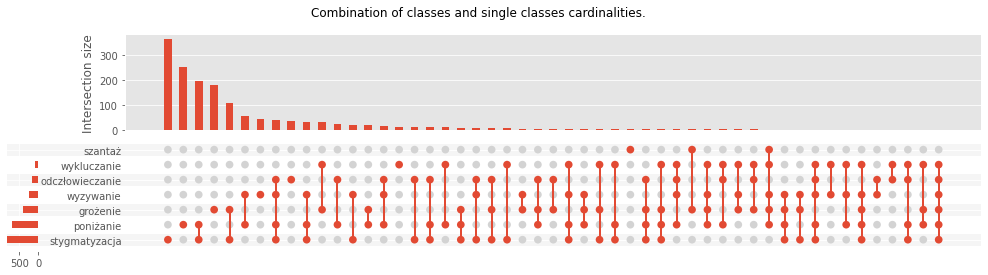

In [16]:
combination_cardinalities_upset(df_combination_cards, color='#e24a33')

## Hateful phrases loading

In [17]:
df_phrases = phrases(df_combined)
df_phrases.head()

,klucze,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,komuchów,1,0,0,0,0,0,0
0,gonić komuchów,1,0,0,0,0,0,0
2,odbierajmy [...] bałwanom,0,0,0,0,1,0,0
19,spocona świnia,0,0,0,0,1,0,0
19,świnia,0,0,0,0,1,0,0


In [18]:
all_phr = np.array([save_raw_phrases(df_phrases, hate_type=label, file=HATEFUL_RAW_DIR.replace('{}', small))
                    for label, small in zip(LABELS, LABELS_SMALL)])

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [19]:
all_phr[0][:5]

array(['komuchów', ' gonić komuchów', 'Kwaśniewski [...] idiota',
       'pojebało kogoś', 'politycy [...] kłapania dziobem'], dtype=object)

In [20]:
all_phr[1][:5]

array(['sądy [...] skasują', 'bomb[...] domy podejrzanych',
       'policzek [...] nie zaszkodzi', 'że was zajebiemy',
       'sądy gówniane'], dtype=object)

In [21]:
all_phr[2][:5]

array(['ryj [...] zakazany', 'prezydent nie wart szacunku',
       ' Premiar morderca, zdrajca', 'wypierdoliliśmy ją z roboty',
       ' nie ma kasy na sądy [...] nam nie skoczy'], dtype=object)

In [22]:
all_phr[3][:5]

array(['komisja śledcza z pachołkami bez wiedzy',
       'prezydent nie wart szacunku', ' Premiar morderca, zdrajca',
       'bomb[...] domy podejrzanych', 'esbeckie złogi'], dtype=object)

In [23]:
all_phr[4][:5]

array(['odbierajmy [...] bałwanom', 'spocona świnia', ' świnia',
       'durne angielskie przepisy', 'Kwaśniewski [...] idiota'],
      dtype=object)

In [24]:
all_phr[5][:5]

array(['sądy [...] to zbytek', ' #Józefmoneta',
       'PiS gwałci żeby nie robić aborcji', 'ryj [...] zakazany',
       'politycy [...] kłapania dziobem'], dtype=object)

In [25]:
all_phr[6][:5]

array(['wypierdalaj stąd, bo zaliczysz zgon',
       ' jesteś kurwą, wypierdalaj', ' wypierdalaj',
       'jak nie odsuniecie [...] to zamkniemy was w pierdlu',
       'jak dalej będziesz tworzyć trudne sądy [...] przez Ciebie przejdę ząłamanie nerwowe'],
      dtype=object)

In [26]:
df_phrase_cards = phrase_cards(all_phr)
df_phrase_cards

,cardinality
hate type,
wyzywanie,459
grożenie,472
wykluczanie,122
odczłowieczanie,348
poniżanie,996
stygmatyzacja,1159
szantaż,10


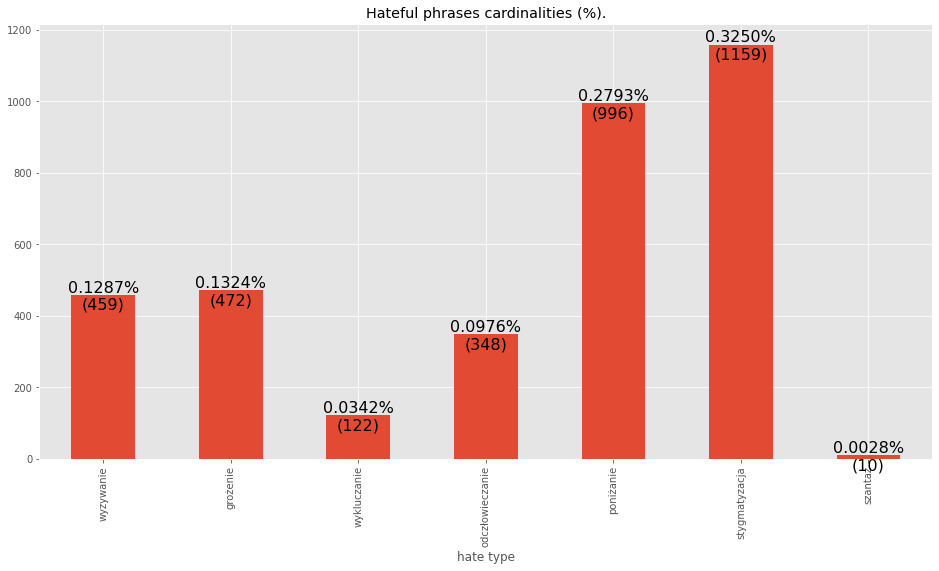

In [27]:
phrase_cardinalities_bar(df_phrase_cards)

## Vulgar phrases loading

In [28]:
with open('data/vulgars/polish_vulgar_words.txt', 'r') as f:
    text = f.read()

vulgar1 = np.array(re.findall(r'\'([A-Za-z0-9_\./\\-]*)\'', text))
f'Set 1: {len(vulgar1)} examples.'

'Set 1: 413 examples.'

In [29]:
with open('data/vulgars/polish_vulgar_words_github.txt', 'r') as f:
    text = f.read()

vulgar2 = np.array(re.findall(r'\"([A-Za-z0-9_\./\\-]*)\"', text))
f'Set 2: {len(vulgar2)} examples.'

'Set 2: 464 examples.'

In [30]:
with open('data/vulgars/polish_vulgar_phrases.txt', 'r') as f:
    text = f.read()
text = text.replace('\n', ' • ')

vulgar3 = np.array(text.split(' • '))
f'Set 3: {len(vulgar3)} examples.'

'Set 3: 423 examples.'

In [31]:
vulgar_words = union3(vulgar1, vulgar2, vulgar3)
f'Total: {len(vulgar_words)} distinct examples.'

'Total: 845 distinct examples.'

In [32]:
save_raw_vulgars(vulgar_words, file=VULGARS_RAW_DIR.replace('{}', 'vulg'))

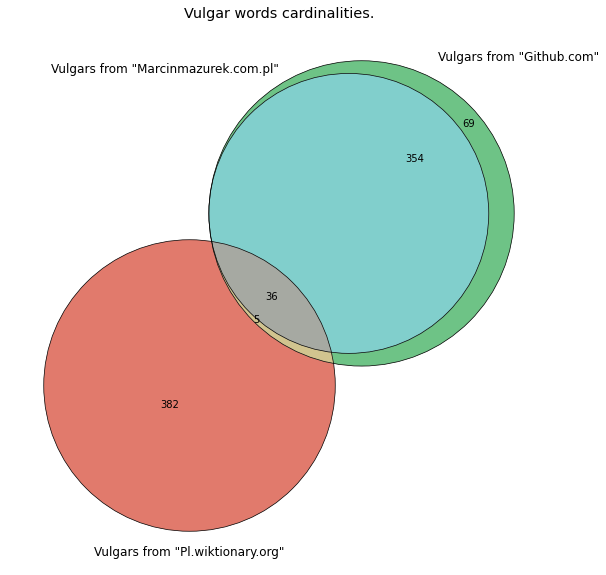

In [33]:
vulgars_cardinalities_venn([vulgar1, vulgar2, vulgar3],
                           ['Vulgars from "Marcinmazurek.com.pl"',
                            'Vulgars from "Github.com"',
                            'Vulgars from "Pl.wiktionary.org"'])

## Empirically annotated sentiment

In [34]:
sentiments = df_combined['wydźwięk'].values
sentiments

array([-1, -1, -1, ...,  1,  0, -1])

In [35]:
u_sentiments, n_sentiments = np.unique(sentiments, return_counts=True)
(u_sentiments, n_sentiments)

(array([-1,  0,  1]), array([2793, 5505, 6904]))

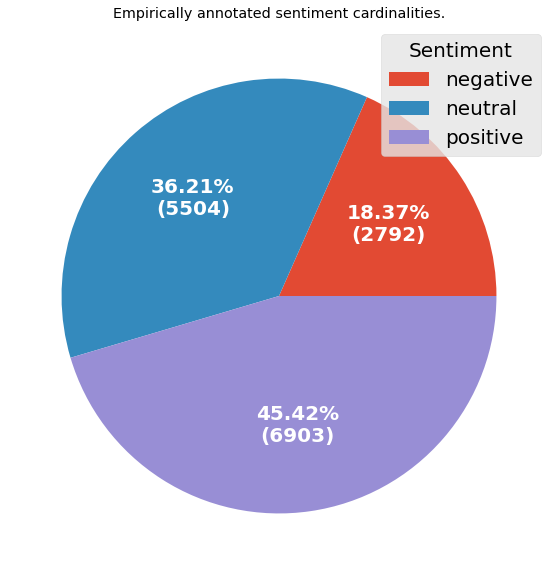

In [36]:
sentiment_counts_pie(n_sentiments, labels=['negative', 'neutral', 'positive'])